In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from PIL import Image
import os

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# For moving all img files from one root dir to another
# source = "Train"
# dest = "Train1"

# label_flood_dir = os.path.join('Labeled','Flooded','image')
# label_nonflood_dir = os.path.join('Labeled','Non-Flooded','image')

# for dire in label_flood_dir,label_nonflood_dir:
#     source_dir = os.path.join(source,dire)
#     dest_dir = os.path.join(dest,dire)
#     for file in os.listdir(source_dir):
#         source_file = os.path.join(source_dir,file)
#         dest_file = os.path.join(dest_dir,file)
#         os.rename(source_file,dest_file)

Should take around 3 minutes to load

In [4]:
h_dim = 1000
v_dim = 750
print("Loading Data from Memory")

root = "Train"
label_flood_dir = os.path.join(root,'Labeled','Flooded','image')
label_nonflood_dir = os.path.join(root,'Labeled','Non-Flooded','image')
flooded_img = []
nonflooded_img = []

for file in os.listdir(label_flood_dir):
    image = Image.open(os.path.join(label_flood_dir, file))
    flooded_img.append(np.array(image.resize((h_dim,v_dim))))
    
for file in os.listdir(label_nonflood_dir):
    image = Image.open(os.path.join(label_nonflood_dir, file))
    nonflooded_img.append(np.array(image.resize((h_dim,v_dim))))
print("Loaded!")

Loading Data from Memory
Loaded!


In [5]:
print(flooded_img[0].shape)

(750, 1000, 3)


In [6]:
print("Flooded Image Shape: {}".format(flooded_img[0].shape))
print("Non_Flooded Image Shape: {}".format(nonflooded_img[0].shape))

Flooded Image Shape: (750, 1000, 3)
Non_Flooded Image Shape: (750, 1000, 3)


In [7]:
data_img = np.vstack((np.array(flooded_img), np.array(nonflooded_img))) / 255.
data_img.shape

(397, 750, 1000, 3)

In [8]:
data_img.max()

1.0

In [9]:
data_img.min()

0.0

In [10]:
np.array(flooded_img).shape

(51, 750, 1000, 3)

In [11]:
import random
test = False

#n is number images from each class (flooded or non flooded)
if test == True:
    n = 20
    #train_idx = np.array([np.arange(7),np.arange(10,17)]).flatten()
    #test_idx = np.array([np.arange(7,10),np.arange(17,20)]).flatten()
else:
    n = min(len(flooded_img),len(nonflooded_img))

'''split data 50 50'''
def train_test_split(n):
    idxs = list(range(n))
    s = int(np.floor(0.8*n)) # number of images for training
    
    train_idx = []
    test_idx = []
    
    #index range to select from (flooded img range, non flooded image range)
    for s_i,e_i in [(0,len(flooded_img)),(len(flooded_img),len(data_img))]:
        
        #print(s_i,e_i,n,s)
        #get all poss indexes for set
        s_idx = list(range(s_i,e_i))
        random.shuffle(s_idx)
        
        train_idx.extend(s_idx[:s])      #first s images are for training
        test_idx.extend(s_idx[s:n])      # next n-s images are for testing. 
        #print(len(train_idx))
    
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    train_idx.sort()
    test_idx.sort()
    
    train_labels = [1 if x<len(flooded_img) else 0 for x in train_idx]
    test_labels = [1 if x<len(flooded_img) else 0 for x in test_idx]

    print("Training Index: {}".format(train_idx))
    print("Testing Index: {}".format(test_idx))
    return train_idx, test_idx, train_labels, test_labels

train_idx, test_idx, train_labels, test_labels = train_test_split(n)


Training Index: [  1   2   3   5   6   7   8   9  11  12  14  15  16  21  22  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  43  44  45  46
  47  48  49  50  51  59  63  93 108 113 114 115 120 126 127 129 130 135
 141 155 158 159 167 178 187 206 217 219 230 231 232 237 284 293 295 309
 322 324 328 333 351 356 374 385]
Testing Index: [  0   4  10  13  17  18  19  20  23  24  42 143 156 189 218 221 263 270
 273 334 355 377]


In [12]:
# convolutional layer
def conv_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[-1]]))

    out = tf.nn.conv2d(input=x, filters=weights, strides=[1,1,1,1], padding='SAME')
    out += bias
    return out

# pooling layer
def max_pool(x, k=2):

    out = tf.nn.max_pool(value=x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return out

# fully connected layer
def fully_connected_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[1]]))

    out = tf.matmul(a=x, b=weights)
    out += bias
    return out

# flatten layer
def flatten_layer(x):
    
    size = x.get_shape()[1:4].num_elements()
    out = tf.reshape(x, [-1,size])
    return out, size

# relu
relu = lambda x: tf.nn.relu(features=x)

# softmax
softmax = lambda x: tf.nn.softmax(logits=x)

In [13]:
def toy_model(x):

    # three convolutional layers with max pool
    shape0 = [5, 5, 3, 3]
    conv0 = conv_layer(x, shape0)
    conv0 = max_pool(conv0, k=2)

    shape1 = [5, 5, 3, 1]
    conv1 = conv_layer(conv0, shape1)
    conv1 = max_pool(conv1, k=2)

    shape2 = [5, 5, 1, 1]
    conv2 = conv_layer(conv1, shape2)
    conv2 = max_pool(conv2, k=2)

    # flatten output and put through a fully connected layer
    flat1, size1 = flatten_layer(conv2)
    fc1 = fully_connected_layer(flat1, [size1, 64])
    fc1 = relu(fc1)

    fc2 = fully_connected_layer(fc1, [64, 2])
    out = softmax(fc2)

    return out

In [20]:
def sharpen(p):
    T = 0.5
    pred = p**(1./T)/(p**(1./T) + (1.-p)**(1./T))
    return pred

In [27]:
# define inputs
x = tf.placeholder(tf.float32, [None, v_dim, h_dim, 3])
y = tf.placeholder(tf.float32, [None, 1])
y_train_true = np.array(train_labels).reshape(-1,1)
y_test_true = np.array(test_labels).reshape(-1,1)

# run model with placeholder tensors
pred = toy_model(x)

# sharpen
pred = sharpen(pred)

# define loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)
cost = tf.reduce_mean(cross_entropy)

# define accuracy
pred_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(pred_correct, tf.float32))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

# initialize variables
init = tf.global_variables_initializer()
training_iters = 100
batch_size = 10#len(train_idx)

Tensor("truediv_4:0", shape=(?, 2), dtype=float32)


In [28]:
# train model
with tf.Session(config=config) as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    num_batches = len(train_idx)//batch_size
    
    for i in range(training_iters):
        
        # Reset metrics
        loss_total = 0
        acc_total = 0
   
        # Run optimization 
        # Calculate batch loss and accuracy
        for batch in range(num_batches):
            batch_x = data_img[train_idx,:,:,:][batch*batch_size:min((batch+1)*batch_size,len(train_idx))]
            batch_y = y_train_true[batch*batch_size:min((batch+1)*batch_size,len(y_train_true))]    

            feed_dict={x: batch_x, y: batch_y}
            opt = sess.run(optimizer, feed_dict=feed_dict)
            loss, acc = sess.run([cost, accuracy], feed_dict=feed_dict)
            loss_total += loss
            acc_total += acc

        # Average metrics
        ave_loss = loss_total/num_batches
        ave_acc = acc_total/num_batches
        
        # Calculate accuracy for all test images
        test_acc,valid_loss = sess.run([accuracy,cost],
                                feed_dict={x: data_img[test_idx,:,:,:], y : y_test_true})
        train_loss.append(ave_loss)
        test_loss.append(valid_loss)
        train_accuracy.append(ave_acc)
        test_accuracy.append(test_acc)
        
        if i%1 == 0:
            print("Iter " + str(i) + ", Loss= " + \
                  "{:.6f}".format(ave_loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(ave_acc)+ ", Testing Accuracy= " + \
                  "{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.703875, Training Accuracy= 0.48750, Testing Accuracy= 0.72727
Iter 1, Loss= 0.693291, Training Accuracy= 0.65000, Testing Accuracy= 0.18182
Iter 2, Loss= 0.693196, Training Accuracy= 0.30000, Testing Accuracy= 0.04545
Iter 3, Loss= 0.693175, Training Accuracy= 0.60000, Testing Accuracy= 1.00000
Iter 4, Loss= 0.693162, Training Accuracy= 0.45000, Testing Accuracy= 1.00000
Iter 5, Loss= 0.693158, Training Accuracy= 0.47500, Testing Accuracy= 1.00000
Iter 6, Loss= 0.693154, Training Accuracy= 0.45000, Testing Accuracy= 1.00000
Iter 7, Loss= 0.693152, Training Accuracy= 0.46250, Testing Accuracy= 1.00000
Iter 8, Loss= 0.693151, Training Accuracy= 0.47500, Testing Accuracy= 1.00000
Iter 9, Loss= 0.693150, Training Accuracy= 0.50000, Testing Accuracy= 0.95455
Iter 10, Loss= 0.693149, Training Accuracy= 0.48750, Testing Accuracy= 0.95455
Iter 11, Loss= 0.693149, Training Accuracy= 0.50000, Testing Accuracy= 0.90909
Iter 12, Loss= 0.693149, Training Accuracy= 0.46250, Testing A

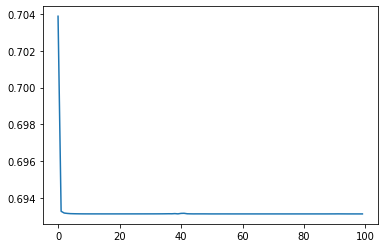

In [29]:
fig,ax = plt.subplots(1,1)
ax.plot(train_loss)
plt.show()